In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
import src.stokes_flow as sf
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from src.objComposite import *
from src.geo import *

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [265]:
from HelicodsParticles import obj_helicoid_hlx

def move_AtBt(At, Bt1, Bt2, ds):    
    Atnew = At
    Bt1new = Bt1 + np.cross(ds, At)
    Bt2new = Bt2 + np.cross(ds, At).T
    return Atnew, Bt1new, Bt2new

def rot_AtBt(At, Bt1, Bt2, norm, theta):
    norm = np.hstack(norm)
    err_msg = 'norm is unite 3D vector'
    assert norm.shape == (3, ), err_msg
    assert np.isclose(np.linalg.norm(norm), 1), err_msg
    
    tM1 = get_rot_matrix(norm, theta)
    Atrot = np.dot(np.dot(tM1, At), tM1.T)
    Bt1rot = np.linalg.det(tM1) * np.dot(np.dot(tM1, Bt1), tM1.T)
    Bt2rot = np.linalg.det(tM1) * np.dot(np.dot(tM1, Bt2), tM1.T)
    return Atrot, Bt1rot, Bt2rot

def helicoid_AtBt(At, Bt1, Bt2, helicoid_r=0, helicoid_ndsk_each=4, ini_th=0):
    assert helicoid_ndsk_each == 4
    assert ini_th == 0
    
    ds = np.array((helicoid_r, 0, 0))
    At, Bt1, Bt2 = move_AtBt(At, Bt1, Bt2, ds)
    
    rot_dth = 2 * np.pi / helicoid_ndsk_each        
    AtBt_list = []
    for i0 in range(helicoid_ndsk_each):
        rot_th = i0 * rot_dth + np.pi / 4
        tAtBt = rot_AtBt(At, Bt1, Bt2, norm=np.array([0, 0, 1]), theta=rot_th)
        AtBt_list.append(tAtBt)
        AtBt_list.append(rot_AtBt(*tAtBt, norm=np.array([1, 0, 0]), theta=np.pi / 2))
        AtBt_list.append(rot_AtBt(*tAtBt, norm=np.array([0, 1, 0]), theta=np.pi / 2))
    return AtBt_list

def helicoid_AtBt_v4(At, Bt1, Bt2, helicoid_r=0, helicoid_ndsk_each=4, ini_th=0):        
    assert helicoid_ndsk_each == 4
    assert ini_th == 0
    AtBt_list = []
    
    tr = helicoid_r / np.sqrt(2)
    tP = np.array((0, 0, 1))
    
    # x great 
    tnorm0 = np.array((0, 1, 0))
    theta0 = np.pi / 2
    tnorm1 = np.array((1, 0, 0))
    tnorm2 = np.array((0, 1, 0))
    rotM = get_rot_matrix(tnorm0, theta0)
    print(np.dot(rotM, tP))
    tAtBt = rot_AtBt(At, Bt1, Bt2, tnorm0, theta0)
    
    ds = np.array((0, +tr, +tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 1*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((0, -tr, tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 3*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((0, -tr, -tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 5*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((0, +tr, -tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 7*np.pi/4)
    AtBt_list.append(t1)
        
    # y great 
    tnorm0 = np.array((1, 0, 0))
    theta0 = -np.pi / 2
    tnorm1 = np.array((0, 1, 0))
    tnorm2 = np.array((0, 0, 1))
    rotM = get_rot_matrix(tnorm0, theta0)
    print(np.dot(rotM, tP))
    tAtBt = rot_AtBt(At, Bt1, Bt2, tnorm0, theta0)
    
    ds = np.array((+tr, 0, +tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 1*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((-tr, 0, tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 3*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((-tr, 0, -tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 5*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((+tr, 0, -tr))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 7*np.pi/4)
    AtBt_list.append(t1)
        
    # y great 
    tnorm0 = np.array((1, 0, 0))
    theta0 = 0
    tnorm1 = np.array((0, 0, 1))
    tnorm2 = np.array((1, 0, 0))
    rotM = get_rot_matrix(tnorm0, theta0)
    print(np.dot(rotM, tP))
    tAtBt = rot_AtBt(At, Bt1, Bt2, tnorm0, theta0)
    
    ds = np.array((+tr, +tr, 0))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 1*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((-tr, tr, 0))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 3*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((-tr, -tr, 0))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 5*np.pi/4)
    AtBt_list.append(t1)
    ds = np.array((+tr, -tr, 0))
    t1 = rot_AtBt(*(rot_AtBt(*(move_AtBt(*tAtBt, ds)), tnorm2, np.pi/4)), tnorm1, 7*np.pi/4)
    AtBt_list.append(t1)
    return AtBt_list


In [266]:
pickle_part_name = 'helicoid_part.pickle'
# pickle_part_name = 'helicoid_part_lft.pickle'
helicoid_r = 100
helicoid_ndsk_each = 4
# ini_th = 2 * np.pi / (2 * helicoid_ndsk_each)
# ini_th = np.random.sample(1) * 2 * np.pi
ini_th = 0
# ini_th = np.pi / 2

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)
At0 = np.random.sample((3, 3))
# Bt1 = np.random.sample((3, 3))
# Bt2 = np.random.sample((3, 3))
At = 0.5 * (At0 + At0.T)
# At = np.zeros_like(At)
Bt1 = np.zeros_like(Bt1)
Bt2 = np.zeros_like(Bt2)

AtBt_list = helicoid_AtBt_v4(At, Bt1, Bt2, helicoid_r, helicoid_ndsk_each, ini_th)
At_sum = np.sum([AtBt[0] for AtBt in AtBt_list], axis=0)
Bt1_sum = np.sum([AtBt[1] for AtBt in AtBt_list], axis=0)
Bt2_sum = np.sum([AtBt[2] for AtBt in AtBt_list], axis=0)
print(At_sum)
print()
print(Bt1_sum)
print()
print(Bt2_sum)

AtBt_list0 = helicoid_AtBt(At, Bt1, Bt2, helicoid_r, helicoid_ndsk_each, 0)
# At_sum0 = np.sum([AtBt[0] for AtBt in AtBt_list0], axis=0)
# Bt1_sum0 = np.sum([AtBt[1] for AtBt in AtBt_list0], axis=0)
# Bt2_sum0 = np.sum([AtBt[2] for AtBt in AtBt_list0], axis=0)
# print(At_sum - At_sum0)
# print()
# print(Bt1_sum - Bt1_sum0)
# print()
# print(Bt2_sum - Bt2_sum0)

[1.000000e+00 0.000000e+00 6.123234e-17]
[0.000000e+00 1.000000e+00 6.123234e-17]
[0. 0. 1.]
[[ 1.98628668e+00  0.00000000e+00 -2.77555756e-16]
 [ 0.00000000e+00  5.84056199e+00  1.66533454e-16]
 [-2.22044605e-16  3.88578059e-16  5.51029826e+00]]

[[-2.84217094e-14 -9.64033185e+00 -1.49116487e+01]
 [-3.59122989e+02 -2.84217094e-14  6.26383077e+01]
 [ 8.22943136e+01 -8.02573061e+01  4.26325641e-14]]

[[-2.13162821e-14 -3.59122989e+02  8.22943136e+01]
 [-9.64033185e+00 -4.26325641e-14 -8.02573061e+01]
 [-1.49116487e+01  6.26383077e+01  6.75015599e-14]]


In [243]:
# pickle_part_name = 'helicoid_part.pickle'
pickle_part_name = 'helicoid_part_lft.pickle'
helicoid_r = 1000
helicoid_ndsk_each = 4
print_idx = 2
# ini_th = 2 * np.pi / (2 * helicoid_ndsk_each)
ini_th = np.random.sample(1) * 2 * np.pi
# ini_th = 0
# ini_th = np.pi / 2

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)
At = 0.5 * (At + At.T)
Bt1 = np.zeros_like(Bt1)
Bt2 = np.zeros_like(Bt2)

AtBt_list = helicoid_AtBt(At, Bt1, Bt2, helicoid_r, helicoid_ndsk_each, ini_th)
At_sum = np.sum([AtBt[0] for AtBt in AtBt_list], axis=0)
Bt1_sum = np.sum([AtBt[1] for AtBt in AtBt_list], axis=0)
Bt2_sum = np.sum([AtBt[2] for AtBt in AtBt_list], axis=0)
print(At_sum)
print()
print(Bt1_sum)
print()
print(Bt2_sum)

[[ 1.38621333e+02  8.88178420e-16  0.00000000e+00]
 [-1.77635684e-15  1.38621333e+02 -2.22044605e-16]
 [-2.22044605e-16  0.00000000e+00  1.21883293e+02]]

[[-1.75505530e+02 -1.47554892e-03 -1.27329258e-11]
 [ 1.47554892e-03 -1.75505530e+02  9.09494702e-13]
 [ 1.27329258e-11  1.27329258e-11  3.51011059e+02]]

[[-1.75505530e+02  1.47554892e-03  1.45519152e-11]
 [-1.47554892e-03 -1.75505530e+02  6.36646291e-12]
 [-1.09139364e-11 -1.81898940e-12  3.51011059e+02]]


In [173]:
At - At.T

array([[ 0.00000000e+00, -3.11224009e-07, -3.66944533e-07],
       [ 3.11224009e-07,  0.00000000e+00, -8.33942997e-05],
       [ 3.66944533e-07,  8.33942997e-05,  0.00000000e+00]])

In [137]:
for AtBt in AtBt_list:
    print(AtBt[1])
    print()

[[ 1.34668459e+00  7.65371206e-05 -3.47364539e-06]
 [-4.18137467e-05  2.38381479e-01 -8.09772176e-01]
 [-1.07667973e-05  3.65964460e+00 -1.98533255e+00]]

[[ 1.34668459e+00  3.47364539e-06  7.65371206e-05]
 [ 1.07667973e-05 -1.98533255e+00 -3.65964460e+00]
 [-4.18137467e-05  8.09772176e-01  2.38381479e-01]]

[[ 1.34668459e+00 -3.47364539e-06 -7.65371206e-05]
 [-1.07667973e-05 -1.98533255e+00 -3.65964460e+00]
 [ 4.18137467e-05  8.09772176e-01  2.38381479e-01]]

[[ 2.38381479e-01  4.18137467e-05  8.09772176e-01]
 [-7.65371206e-05  1.34668459e+00 -3.47364539e-06]
 [-3.65964460e+00 -1.07667973e-05 -1.98533255e+00]]

[[-1.98533255e+00 -1.07667973e-05  3.65964460e+00]
 [-3.47364539e-06  1.34668459e+00  7.65371206e-05]
 [-8.09772176e-01 -4.18137467e-05  2.38381479e-01]]

[[-1.98533255e+00  1.07667973e-05  3.65964460e+00]
 [ 3.47364539e-06  1.34668459e+00 -7.65371206e-05]
 [-8.09772176e-01  4.18137467e-05  2.38381479e-01]]

[[ 1.34668459e+00  7.65371206e-05  3.47364539e-06]
 [-4.18137467e-05  

In [103]:
%matplotlib notebook

pickle_part_name = 'helicoid_part.pickle'

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)
tail_obj_list = create_ecoli_tail(moveh=np.zeros(3), **problem_kwargs)
tobj = sf.StokesFlowObj()
tobj.combine(tail_obj_list)
tobj.set_name('helicoid_hlx')
# tobj.node_rotation(norm=np.array([1, 0, 0]), theta=th_loc)
helicoid_comp = obj2helicoid_comp(tobj, **problem_kwargs)
# helicoid_comp.show_u_nodes(linestyle='')

ndsk_each = problem_kwargs['helicoid_ndsk_each']
rotM_list = []
rot_dth = 2 * np.pi / ndsk_each
for i0 in range(ndsk_each):
    rot_th = i0 * rot_dth + rot_dth / 2
    tM1 = get_rot_matrix((0, 0, 1), rot_th)
    tM2 = np.dot(get_rot_matrix((1, 0, 0), np.pi / 2), tM1)
    tM3 = np.dot(get_rot_matrix((0, 1, 0), np.pi / 2), tM1)
    rotM_list.append(tM1)
    rotM_list.append(tM2)
    rotM_list.append(tM3)
# base_norm = tobj.get_u_geo().get_geo_norm()
# for rotM, tobj in zip(rotM_list, helicoid_comp.get_obj_list()):
#     print(np.dot(rotM, base_norm) - tobj.get_u_geo().get_geo_norm())

At_sum = np.zeros((3, 3))
for rotM in rotM_list:
    At_sum = At_sum + np.dot(np.dot(rotM, At), rotM.T)
print(At_sum)

Bt1_sum = np.zeros((3, 3))
for rotM in rotM_list:
    Bt1_sum = Bt1_sum + np.dot(np.dot(rotM, Bt1), rotM.T)
print(Bt_sum)

Bt2_sum = np.zeros((3, 3))
for rotM in rotM_list:
    Bt2_sum = Bt2_sum + np.dot(np.dot(rotM, Bt2), rotM.T)
print(Bt_sum)

[[ 1.33041946e+02 -6.22448017e-07 -6.22448018e-07]
 [ 6.22448018e-07  1.33041946e+02 -6.22448017e-07]
 [ 6.22448017e-07  6.22448018e-07  1.33041946e+02]]
[[-1.23201095e+00  6.00592203e+00 -2.12937307e-16]
 [-6.00592203e+00 -1.23201095e+00 -6.85419061e-16]
 [ 6.54180486e-16  5.67647600e-16 -1.23201095e+00]]
[[-1.23201095e+00  6.00592203e+00 -2.12937307e-16]
 [-6.00592203e+00 -1.23201095e+00 -6.85419061e-16]
 [ 6.54180486e-16  5.67647600e-16 -1.23201095e+00]]


In [31]:
At

array([[ 8.07255256e+00,  1.60005545e-06, -1.18986399e-06],
       [ 1.27499743e-06,  8.08875997e+00, -5.87374659e-02],
       [-4.90339715e-07, -5.88192187e-02,  6.20529277e+00]])

In [28]:
Bt1

array([[ 9.01463370e-01,  2.98070648e-05, -6.49582604e-07],
       [-5.16624958e-05,  1.23148953e-01, -5.44087929e-01],
       [-5.30951755e-05,  2.45973311e+00, -1.33288647e+00]])

In [29]:
Bt2

array([[ 9.01722359e-01, -1.34584296e-04, -4.19296168e-05],
       [ 6.32282308e-05,  1.23161332e-01,  2.45902729e+00],
       [ 4.36822328e-07, -5.44173897e-01, -1.33288643e+00]])

In [36]:
Ct

array([[ 4.08770981e+02, -5.81599833e-05,  1.70187342e-04],
       [-2.71584733e-04,  4.11143660e+02, -1.09424011e+01],
       [ 1.63727264e-04, -1.09417270e+01,  2.00629698e+01]])

<IPython.core.display.Javascript object>


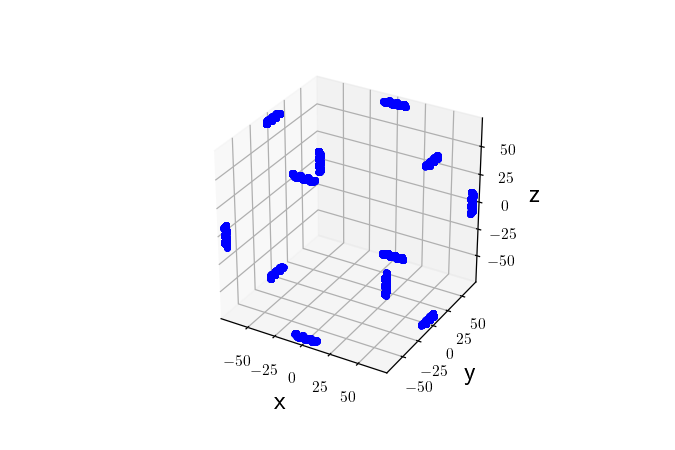

helicoid_hlx_00_0
helicoid_hlx_00_1
helicoid_hlx_00_2
helicoid_hlx_01_0
helicoid_hlx_01_1
helicoid_hlx_01_2
helicoid_hlx_02_0
helicoid_hlx_02_1
helicoid_hlx_02_2
helicoid_hlx_03_0
helicoid_hlx_03_1
helicoid_hlx_03_2


In [75]:
pickle_part_name = 'helicoid_part.pickle'

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)
tail_obj_list = create_ecoli_tail(moveh=np.zeros(3), **problem_kwargs)
tobj0 = sf.StokesFlowObj()
tobj0.combine(tail_obj_list)
tobj0.set_name('helicoid_hlx')
helicoid_r = problem_kwargs['helicoid_r']

namehandle = tobj0.get_name()
t1 = helicoid_r * 0.5 * np.sqrt(2)
tobj0.move((t1, t1, 0))
tobj1 = tobj0.copy()
tobj1.node_rotation(np.array((1, 0, 0)), np.pi / 2, rotation_origin=np.zeros(3))
tobj2 = tobj0.copy()
tobj2.node_rotation(np.array((1, 0, 0)), -np.pi / 2, rotation_origin=np.zeros(3))

tobj_list = []
rot_dth = 2 * np.pi / ndsk_each
for i0 in range(ndsk_each):
    rot_th = i0 * rot_dth
    for i1, tobji in enumerate((tobj0, tobj1, tobj2)):
        tobji_i0 = tobji.copy()
        tobji_i0.set_name('%s_%02d_%01d' % (namehandle, i0, i1))
        tobji_i0.node_rotation(np.array((0, 0, 1)), rot_th, rotation_origin=np.zeros(3))
        tobj_list.append(tobji_i0)
tobj = sf.StokesFlowObj()
tobj.combine(tobj_list)
tobj.show_u_nodes(linestyle='')
for tobji in tobj_list:
    print(tobji.get_name())


<IPython.core.display.Javascript object>


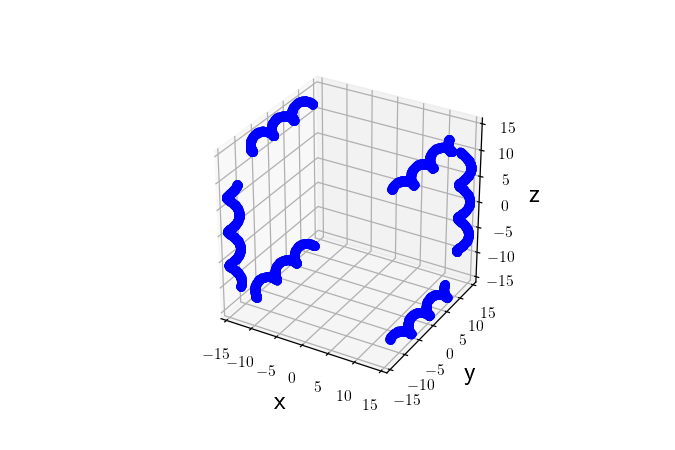

True

In [115]:
pickle_part_name = 'helicoid_part.pickle'

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)
problem_kwargs['helicoid_r'] = 20
problem_kwargs['helicoid_ndsk_each'] = 2
helicoid_comp = obj_helicoid_hlx.create_helicoid_hlx_comp(**problem_kwargs)
helicoid_comp.show_u_nodes(linestyle='')

<IPython.core.display.Javascript object>


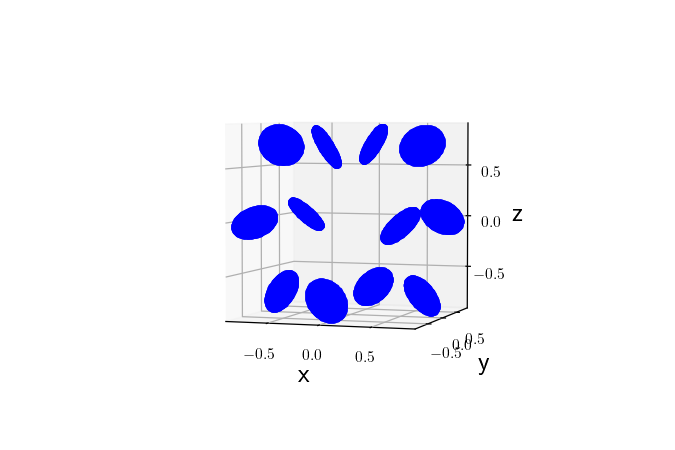

True

In [201]:
problem_kwargs = {'helicoid_r1': 1, 
                  'helicoid_r2': 0.2, 
                  'helicoid_ds': 0.01, 
                  'helicoid_th_loc': np.pi / 4 * 1, 
                  'helicoid_ndsk_each': 4, 
                  'matrix_method': 'rs'}
helicoid_comp = create_helicoid_comp(namehandle='helicoid', **problem_kwargs)
helicoid_comp.show_u_nodes(linestyle='')

In [198]:
from src.geo import *

<IPython.core.display.Javascript object>


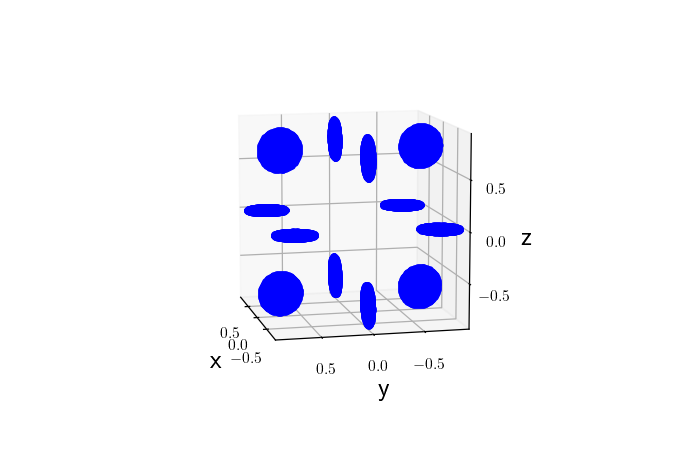

True

In [200]:
problem_kwargs = {'helicoid_r': 1, 
                  'helicoid_r2': 0.2, 
                  'helicoid_ds': 0.01, 
                  'helicoid_th_loc': np.pi / 4 * 0, 
                  'helicoid_ndsk_each': 4, 
                  'matrix_method': 'rs'}

r2 = problem_kwargs['helicoid_r2']
ds = problem_kwargs['helicoid_ds']
th_loc = problem_kwargs['helicoid_th_loc']
tgeo = regularizeDisk()
tgeo.create_ds(ds, r2)
tgeo.node_rotation(norm=np.array([1, 0, 0]), theta=th_loc)
tobj = sf.StokesFlowObj()
tobj.set_data(f_geo=tgeo, u_geo=tgeo, name=namehandle + '%02d' % i0)

helicoid_list = obj2helicoid_list_v2(tobj, **problem_kwargs)
helicoid_comp = sf.ForceFreeComposite(center=np.zeros(3), norm=np.array((1, 0, 0)),
                                      name='helicoid_comp')
for tobj in helicoid_list:
    helicoid_comp.add_obj(obj=tobj, rel_U=np.zeros(6))
helicoid_comp.show_u_nodes(linestyle='')

<IPython.core.display.Javascript object>


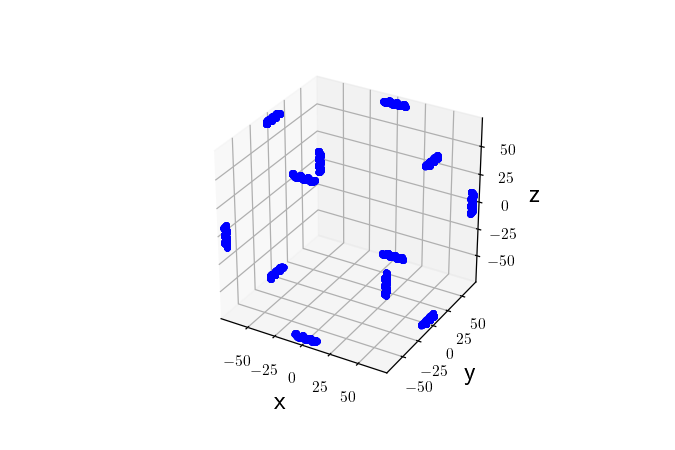

True

In [195]:
pickle_part_name = 'helicoid_hlx.pickle'

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)

t = create_ecoli_tail(moveh=np.zeros(3), **problem_kwargs)
tobj = sf.StokesFlowObj()
tobj.combine(tail_obj_list)
tobj.set_name('helicoid_hlx')
helicoid_list = obj2helicoid_list_v2(tobj, **problem_kwargs)
helicoid_comp = sf.ForceFreeComposite(center=np.zeros(3), norm=np.array((1, 0, 0)),
                                      name='helicoid_comp')
for tobj in helicoid_list:
    helicoid_comp.add_obj(obj=tobj, rel_U=np.zeros(6))
helicoid_comp.show_u_nodes(linestyle='')

## version 2

In [2]:
from HelicodsParticles import obj_helicoid_hlx

def move_AtBt(At, Bt1, Bt2, ds):    
    Atnew = At
    Bt1new = Bt1 + np.cross(ds, At)
    Bt2new = Bt2 + np.cross(ds, At).T
    return Atnew, Bt1new, Bt2new

def rot_AtBt(At, Bt1, Bt2, norm, theta):
    norm = np.hstack(norm)
    err_msg = 'norm is unite 3D vector'
    assert norm.shape == (3, ), err_msg
    assert np.isclose(np.linalg.norm(norm), 1), err_msg
    
    tM1 = get_rot_matrix(norm, theta)
    Atrot = np.dot(np.dot(tM1, At), tM1.T)
    Bt1rot = np.linalg.det(tM1) * np.dot(np.dot(tM1, Bt1), tM1.T)
    Bt2rot = np.linalg.det(tM1) * np.dot(np.dot(tM1, Bt2), tM1.T)
    return Atrot, Bt1rot, Bt2rot

def res_helicoid(At, Bt1, Bt2, ds, norm, theta):
#     t1 = (np.sum(np.abs(At)) - np.trace(np.abs(At))) / np.trace(np.abs(At))
#     assert t1 < 1e-5, t1

    Atnew, Bt1new, Bt2new = rot_AtBt(At, Bt1, Bt2, norm, theta)
    Bt2new = Bt2new.T
    # b01 + Sqrt[2] b02 - b10 - Sqrt[2] b20 - Sqrt[2] a01 helicoidR + a02 helicoidR
    res1 = Bt1new[0][1] + np.sqrt(2) * Bt1new[0][2] - Bt1new[1][0] - np.sqrt(2) * Bt1new[2][0] +\
           - np.sqrt(2) * Atnew[0][1] * ds + Atnew[0][2] * ds
    res2 = Bt2new[0][1] + np.sqrt(2) * Bt2new[0][2] - Bt2new[1][0] - np.sqrt(2) * Bt2new[2][0] +\
           - np.sqrt(2) * Atnew[0][1] * ds + Atnew[0][2] * ds
    return res1, res2

  

In [3]:
from scipy.optimize import root as sproot
from scipy.spatial.transform import Rotation as spR

def wrapper_res_fun0(norm, At, Bt1, Bt2, helicoid_r):
    tnorm = norm / np.linalg.norm(norm)
    theta = np.linalg.norm(norm)
    return res_helicoid(At, Bt1, Bt2, helicoid_r, tnorm, theta)[0]
def wrapper_res_fun1(norm, At, Bt1, Bt2, helicoid_r):
    tnorm = norm / np.linalg.norm(norm)
    theta = np.linalg.norm(norm)
    return res_helicoid(At, Bt1, Bt2, helicoid_r, tnorm, theta)[1]

pickle_part_name = 'helicoid_part.pickle'
helicoid_r = 100
norm = np.random.sample(3)
norm = norm / np.linalg.norm(norm)
theta = np.random.sample(1)
method='linearmixing'
# method='excitingmixing'

with open(pickle_part_name, 'rb') as handle:
    problem_kwargs, At, Bt1, Bt2, Ct = pickle.load(handle)

sol = sproot(wrapper_res_fun1, x0=norm * theta, args=(At, Bt1, Bt2, helicoid_r), 
             method=method)
tn = sol.x / np.linalg.norm(sol.x)
th = np.linalg.norm(sol.x)
print(tn, th)

[-0.69368463  0.04695503  0.71874673] 0.012652571338659073


In [ ]:
def helicoid_AtBt(At, Bt1, Bt2, helicoid_r=0, helicoid_ndsk_each=4, ini_th=0):
    assert helicoid_ndsk_each == 4
    assert ini_th == 0
    
    ds = np.array((helicoid_r, 0, 0))
    At, Bt1, Bt2 = move_AtBt(At, Bt1, Bt2, ds)
    
    rot_dth = 2 * np.pi / helicoid_ndsk_each        
    AtBt_list = []
    for i0 in range(helicoid_ndsk_each):
        rot_th = i0 * rot_dth + np.pi / 4
        tAtBt = rot_AtBt(At, Bt1, Bt2, norm=np.array([0, 0, 1]), theta=rot_th)
        AtBt_list.append(tAtBt)
        AtBt_list.append(rot_AtBt(*tAtBt, norm=np.array([1, 0, 0]), theta=np.pi / 2))
        AtBt_list.append(rot_AtBt(*tAtBt, norm=np.array([0, 1, 0]), theta=np.pi / 2))
    return AtBt_list